# Learning disentangled representations in 'sphere-world' with an object that can also change color

## 1. Preamble

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

import time
from IPython import display

try:
    import seaborn as sns
    sns.set()
    print("Set seaborn plotting defaults.")
except:
    print("seaborn not found.")

Set seaborn plotting defaults.


In [2]:
def mk_dir(export_dir, quite=False):
    if not os.path.exists(export_dir):
            try:
                os.makedirs(export_dir)
                print('created dir: ', export_dir)
            except OSError as exc: # Guard against race condition
                 if exc.errno != exc.errno.EEXIST:
                    raise
            except Exception:
                pass
    else:
        print('dir already exists: ', export_dir)

mk_dir("_data/")

created dir:  _data/


## 2. Defining objects

### SphereWorld environment

We use a cubic 3D world in which a ball evolves on a sphere. Observations are a 3-dimensional tensor with values 0 except at the voxel occupied by the ball which has value 1. When the ball is not at the center of the voxel (which is most of the time) its density is distributed around neighboring voxels.

The ball can also "change color"; in our implementation color is encoded as the numerical value of a voxel in a corner; we note that other ways of encoding color could be used.

Actions are discrete rotations around the three axes and changes in color.

In [3]:
class SphereWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))       

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,dim=5,num_colors=5,radius=3.5):

        self.size = dim
        self.num_colors = num_colors
        self.radius = radius
        self.action_space = self.action_space(8)
        self.observation_space = self.observation_space((2*dim)**3)
        
        self.reset()
        
    def reset(self):

        self.theta = random.uniform(0, np.pi)
        self.phi = random.uniform(0, np.pi*2)
        self.color = random.randrange(self.num_colors)

        self.ball_coordinates = [self.radius*np.sin(self.theta)*np.cos(self.phi), \
                                 self.radius*np.sin(self.theta)*np.sin(self.phi), \
                                 self.radius*np.cos(self.theta)]  

        self.state = self.get_state()
        return self.get_observation()
    
    def get_state(self, ball_coordinates=None):
        if ball_coordinates is None:
            ball_coordinates=self.ball_coordinates

        state = torch.zeros((2*self.size, 2*self.size, 2*self.size))

        ball_low_x = ball_coordinates[0] + self.size - .5
        ball_low_y = ball_coordinates[1] + self.size - .5
        ball_low_z = ball_coordinates[2] + self.size - .5

        fill_x = (int(ball_low_x + 1) - ball_low_x)
        fill_y = (int(ball_low_y + 1) - ball_low_y)
        fill_z = (int(ball_low_z + 1) - ball_low_z)

        state[int(ball_low_x), int(ball_low_y), int(ball_low_z)] \
        = fill_x * fill_y * fill_z
        state[(int(ball_low_x) + 1), int(ball_low_y), int(ball_low_z)] \
        = (1 - fill_x) * fill_y * fill_z
        state[int(ball_low_x), (int(ball_low_y) + 1), int(ball_low_z)] \
        = fill_x * (1 - fill_y) * fill_z
        state[(int(ball_low_x) + 1), (int(ball_low_y) +1), int(ball_low_z)] \
        = (1 - fill_x) * (1 - fill_y) * fill_z
        state[int(ball_low_x), int(ball_low_y), int(ball_low_z) + 1] \
        = fill_x * fill_y * (1 - fill_z)
        state[(int(ball_low_x) + 1), int(ball_low_y), int(ball_low_z) + 1] \
        = (1 - fill_x) * fill_y * (1 - fill_z)
        state[int(ball_low_x), (int(ball_low_y) + 1), int(ball_low_z) + 1] \
        = fill_x * (1 - fill_y) * (1 - fill_z)
        state[(int(ball_low_x) + 1), (int(ball_low_y) +1), int(ball_low_z) + 1] \
        = (1 - fill_x) * (1 - fill_y) * (1 - fill_z)

        state[0, 0, 0] = self.color / (self.num_colors - 1)

        self.state = state
        return self.state      

    def get_observation(self):
        return self.state.flatten()

    def step(self, action, angle):

        ball_coordinates = self.ball_coordinates

        if action == 0 or action == 1:
            if action == 1:
                angle = - angle
            new_ball_coordinates = [ball_coordinates[0]*np.cos(angle) + ball_coordinates[1]*np.sin(angle), \
                                    - ball_coordinates[0]*np.sin(angle) + ball_coordinates[1]*np.cos(angle), \
                                    ball_coordinates[2]]
        elif action == 2 or action == 3:
            if action == 3:
                angle = -angle
            new_ball_coordinates = [ball_coordinates[0]*np.cos(angle) + ball_coordinates[2]*np.sin(angle), \
                                    ball_coordinates[1], \
                                    - ball_coordinates[0]*np.sin(angle) + ball_coordinates[2]*np.cos(angle)]
        elif action == 4 or action == 5:
            if action == 5:
                angle = -angle
            new_ball_coordinates = [ball_coordinates[0], \
                                    ball_coordinates[1]*np.cos(angle) + ball_coordinates[2]*np.sin(angle), \
                                    - ball_coordinates[1]*np.sin(angle) + ball_coordinates[2]*np.cos(angle)]
        elif action == 6 or action == 7:
            if action == 6:
                self.color = (self.color + 1) % self.num_colors
            if action == 7:
                self.color = (self.color - 1) % self.num_colors
            new_ball_coordinates = ball_coordinates
        else:
            raise Exception("INVALID ACTION")

        self.ball_coordinates = new_ball_coordinates
        self.state = self.get_state()
        return self.get_observation()

Show observations from the sphere world

7
7
7
7
7


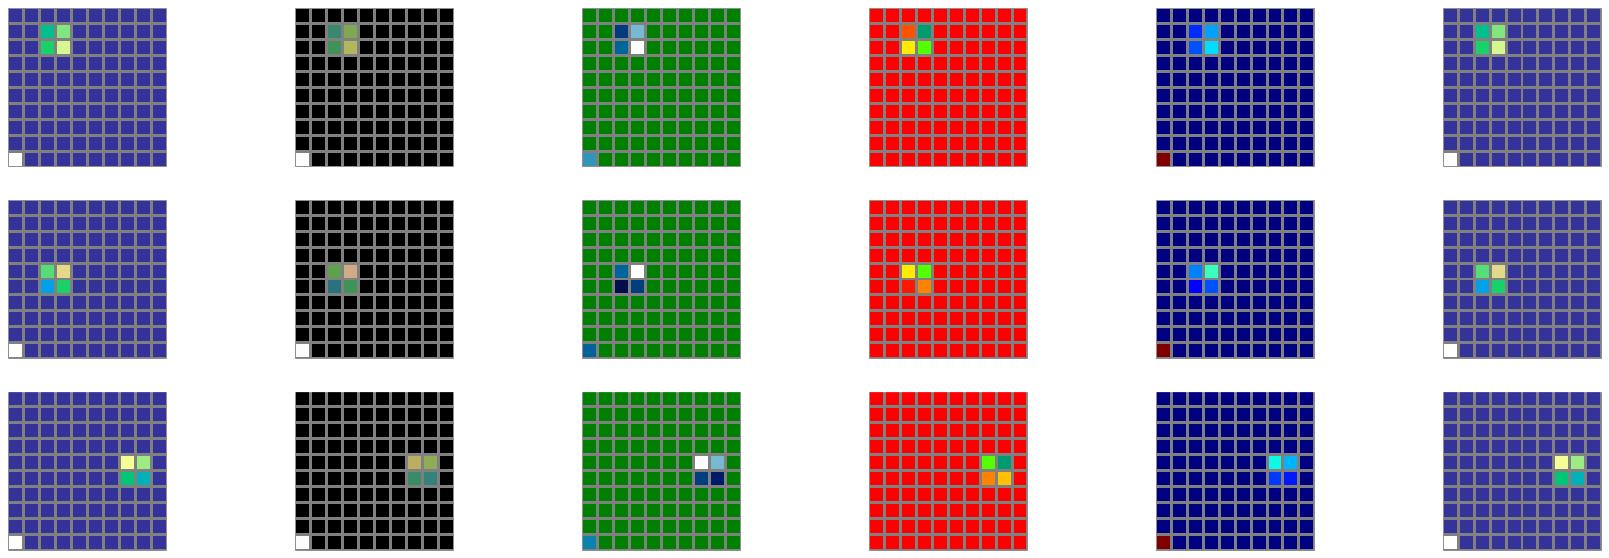

In [4]:
def plot_state(state, ax):
    ax[0].pcolormesh(state.sum(axis=0), edgecolors='gray', \
                     linewidth=2, cmap=colors[round(state[0,0,0].item()*4)])
    ax[0].set_aspect("equal")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].pcolormesh(state.sum(axis=1), edgecolors='gray', \
                     linewidth=2, cmap=colors[round(state[0,0,0].item()*4)])
    ax[1].set_aspect("equal")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[2].pcolormesh(state.sum(axis=2), edgecolors='gray', \
                     linewidth=2, cmap=colors[round(state[0,0,0].item()*4)])
    ax[2].set_aspect("equal")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    return ax
    
n_steps = 5

env = SphereWorld()
colors = ['prism', 'ocean', 'gist_earth', 'terrain', 'jet']
fig, axs = plt.subplots(3, n_steps+1, figsize=(30, 10))

plot_state(env.state,axs[:,0])

for i in range(n_steps):
    action = 7
    print(action)
    env.step(action, 2*np.pi/5)
    plot_state(env.state,axs[:,i+1])

### Latent space

**Encoder/Decoder**

Now we want to learn to represent this environment in some latent space (which we, for now, simply assume to be 5-dimensional).  We will require both an encoder and decoder.

In [5]:
class Coder(nn.Module):

    def __init__(self, n_in, n_out, n_hid=[16], output_activation=nn.Sigmoid):
        super().__init__()
        
        if type(n_hid) != list:
            n_hid = [n_hid]
        n_layers = [n_in] + n_hid + [n_out]

        self.layers = []
        for i_layer, (n1, n2) in enumerate(zip(n_layers, n_layers[1:])):
            mods = [nn.Linear(n1, n2, bias=True)]
            act_fn = nn.ReLU if i_layer < len(n_layers) - 2 else output_activation
            if act_fn is not None:
                mods.append(act_fn())
            layer = nn.Sequential(*mods)
            self.layers.append(layer)

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class nnNorm(nn.Module):
    
    def __init__(self, dim=-1):
        super().__init__()
        self.dim=dim
        
    def forward(self, x):
        return F.normalize(x, dim=self.dim)
    
class Decoder(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=nn.Sigmoid)
        
class Encoder(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=nnNorm)

In [6]:
encoder = Encoder(n_in=5*5*5, n_out=6, n_hid=[16])
print(encoder)

decoder = Decoder(n_in=6, n_out=5*5*5, n_hid=[16])
print(decoder)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(encoder)

Encoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=125, out_features=16, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=6, bias=True)
      (1): nnNorm()
    )
  )
)
Decoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=125, bias=True)
      (1): Sigmoid()
    )
  )
)


2118

Check dimensions

In [7]:
x = torch.rand(125)
z = encoder(x)
x_recon = decoder(z)
print("Observable rep (shape = {}) : \n {}".format(x.shape, x))
print("Latent rep (shape = {}, norm = {}) : \n {}".format(z.shape, torch.norm(z), z))
print("Reconstructed Observable rep (shape = {}) : \n {}".format(x_recon.shape, x_recon))

Observable rep (shape = torch.Size([125])) : 
 tensor([0.6761, 0.4820, 0.7408, 0.2386, 0.3486, 0.2950, 0.8632, 0.8790, 0.8269,
        0.4200, 0.7829, 0.6518, 0.4770, 0.2077, 0.7223, 0.8875, 0.8376, 0.6497,
        0.1558, 0.7254, 0.2747, 0.7799, 0.4912, 0.8103, 0.0544, 0.9080, 0.1421,
        0.9176, 0.6991, 0.6408, 0.5825, 0.3857, 0.5358, 0.0152, 0.4510, 0.5514,
        0.7959, 0.1915, 0.1922, 0.7259, 0.5406, 0.2116, 0.6574, 0.7666, 0.1712,
        0.3441, 0.0542, 0.6058, 0.6850, 0.7394, 0.4468, 0.1122, 0.3258, 0.2841,
        0.7519, 0.5401, 0.0196, 0.9722, 0.5374, 0.9505, 0.8633, 0.8376, 0.3554,
        0.5921, 0.5202, 0.5923, 0.6955, 0.0742, 0.9440, 0.4858, 0.4068, 0.6569,
        0.8637, 0.4485, 0.4143, 0.9760, 0.3303, 0.5757, 0.3738, 0.8466, 0.1429,
        0.5652, 0.3835, 0.3634, 0.6160, 0.5427, 0.9429, 0.2058, 0.2615, 0.4748,
        0.9359, 0.4714, 0.7497, 0.2833, 0.5276, 0.2132, 0.9034, 0.4006, 0.7558,
        0.6108, 0.1836, 0.3713, 0.1677, 0.9924, 0.7160, 0.4070, 0.8322, 0

**Representation**

The crux of the matter is learning to 'represent' actions in the observation space with actions in latent space.  Here, we will do this by assuming every action is a generalized rotation in latent space, which we denote with a series of 2-dimensional rotations.

A 2-d rotation is given by:

\begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}

and we denote a rotation in dimensions $i$ and $j$ of a higher dimensional space as $R_{i,j}(\theta)$.  For $i=1$, $j=4$, in a 4-dimensional space:

\begin{equation}
R_{1,4}(\theta) = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & \sin(\theta) \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}
\end{equation}

An arbitrary rotation, denoted $g$ as I am subtly moving towards this being a group action, can then be written as:

\begin{equation}
    g(\theta_{1,2},\theta_{1,3},\dots,\theta_{n-1,n}) = \prod_{i=1}^{n-1} \prod_{j=1+1}^{n} R_{i,j}(\theta_{i,j})
\end{equation}

which has $n(n-1)/2$ free parameters (i.e. $\theta_{i,j}$'s).

In [8]:
class Representation():

    def __init__(self, dim=5):
        self.dim = dim
        self.params = dim*(dim-1)//2
        self.thetas = torch.autograd.Variable(torch.rand(self.params), requires_grad=True)

        self.__matrix = None
    
    def set_thetas(self, thetas):
        self.thetas = thetas
        self.thetas.requires_grad = True
        self.clear_matrix()
    
    def clear_matrix(self):
        self.__matrix = None
        
    def get_matrix(self):
        if self.__matrix is None:
            k = 0
            mats = []
            for i in range(self.dim-1):
                for j in range(self.dim-1-i):
                    theta_ij = self.thetas[k]
                    k+=1
                    c, s = torch.cos(theta_ij), torch.sin(theta_ij)

                    rotation_i = torch.eye(self.dim, self.dim)
                    rotation_i[i, i] = c
                    rotation_i[i, i+j+1] = s
                    rotation_i[j+i+1, i] = -s
                    rotation_i[j+i+1, j+i+1] = c

                    mats.append(rotation_i)

            def chain_mult(l):
                if len(l)>=3:
                    return l[0]@l[1]@chain_mult(l[2:])
                elif len(l)==2:
                    return l[0]@l[1]
                else:
                    return l[0]

            self.__matrix = chain_mult(mats)
                                    
        return self.__matrix

**LatentWorld**

Now, for symmetry's sake, we'll also have a `LatentWorld` which acts as the environment in the latent space.

In [9]:
class LatentWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,
                 dim=5,
                 n_actions=8,
                 action_reps=None):

        self.dim = dim

        self.action_space = self.action_space(n_actions)
        self.observation_space = self.observation_space(dim)
        
        if action_reps is None:
            self.action_reps = [Representation(dim=self.dim) for _ in range(n_actions)]
        else:
            if len(action_reps)!=n_actions:
                raise Exception("Must pass an action representation for every action.")
            if not all([rep.dim==self.dim]):
                raise Exception("Action representations do not act on the dimension of the latent space.")
            self.action_reps = action_reps
        
    def reset(self, state):
        self.state = state
        return self.get_observation()
    
    def clear_representations(self):
        for rep in self.action_reps:
            rep.clear_matrix()
            
    def get_representation_params(self):
        params = []
        for rep in self.action_reps:
            params.append(rep.thetas)
        return params
    
    def save_representations(self, path):
        if os.path.splitext(path)[-1] != '.pth':
            path += '.pth'
        rep_thetas = [rep.thetas for rep in self.action_reps]
        return torch.save(rep_thetas, path)
    
    def load_reprentations(self, path):
        rep_thetas = torch.load(path)
        for rep in self.action_reps:
            rep.set_thetas(rep_thetas.pop(0))
            
    def get_observation(self):
        return self.state
    
    def step(self,action):
        self.state = torch.mv(self.action_reps[action].get_matrix(), self.state)
        obs = self.get_observation()
        return obs

## 5. Disentanglement

***Some jargon***

We focus on learning a *disentangled* representation of the actions.

Before considering how best to do this, we want to define a metric of 'disentanglement'.  We consider the evolution of an observable (latent) vector, $x \in X$ ($z \in Z$), under the element $g \in G$ of the group of symmetries generating transformations of the object.  Then we are looking for a representation, $\rho:G \rightarrow GL(V)$, such that the transformation is linear in the latent space, i.e.
\begin{equation}
    z^{\prime} = \rho(g) \cdot z.
\end{equation}
Note, in our case, the representations are the rotation matrices we learn.

For this representation to be disentangled, it means that if there exists a subgroup decomposition of $G$
\begin{equation}
    G = G_1 \times G_2 \times \dots \times G_n,
\end{equation}
then we equivalently decompose the representation, $(\rho, G)$, into subrepresentations:
\begin{equation}
    V = V_1 \oplus V_2 \oplus \dots \oplus V_n
\end{equation}
such that the restricted subrepresentations $(\rho_{\vert G_i}, V_i)_i$ are non-trivial, and the restricted subrepresentations $(\rho_{\vert G_i}, V_j)_{j \neq i}$ are trivial.

In our context, a SphereWorld can be represented as a subgroup of $\mathrm{SO}(3) \times \mathrm{SO}(2)$, therefore we hope to find the disentangled representation of 6 rotations and 2 changes in color that correspond to this.

***Some practicalities***

Our intuition is that the disentangled representation acts as the identity on as many dimensions as possible.  We could attempt to enforce this with some regularization during training.  Normal weight decay won't cut it, as that tries to reduce all weights, where as what we really want to do is have all *but one* of our thetas (which corresponds to the rotation/coupling of two dimensions) to be zero.

**1. Entanglement regularisation**

So for $m$ parameters, ${\theta_1, \dots, \theta_m}$, we want to regularise with
\begin{equation}
    \sum_{i \neq j} \vert\theta_i\vert^2, \mathrm{where\ } \theta_j {=} \mathrm{max_k}({\vert\theta_k\vert}).
\end{equation}
We will also use this term as our metric of 'entanglement'.

In [10]:
def calc_entanglement(params):
    params = params.abs().pow(2)
    return params.sum() - params.max()

params = torch.FloatTensor([1,1,0.5,0,0])
calc_entanglement(params)

tensor(1.2500)

### Training with regularization

Note: undesirable local minima are known to exist (in particular the loss can sometimes get stuck at 8e-3), which can sometimes lead to learning poor representations

In [17]:
obs_env = SphereWorld(dim = 5, radius = 4., num_colors=5)
lat_env = LatentWorld(dim = 5,
                      n_actions = obs_env.action_space.n
                     )
decoder = Decoder(n_in = sum(lat_env.observation_space.shape),
                  n_out = sum(obs_env.observation_space.shape),
                  n_hid = [64])

encoder = Encoder(n_in = sum(obs_env.observation_space.shape),
                  n_out = sum(lat_env.observation_space.shape),
                  n_hid = [64])

optimizer_dec = optim.Adam(decoder.parameters(),
                           lr=3e-2,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

optimizer_enc = optim.Adam(encoder.parameters(),
                           lr=4e-2,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

optimizer_rep = optim.Adam(lat_env.get_representation_params(),
                           lr=3e-2,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

losses = []
entanglement = []
orthogonality = []

In [18]:
n_sgd_steps = 15000
ep_steps = 5
batch_eps = 16

angle = np.pi * 2/5

i = 1

t_start = time.time()

temp = 0

while i < n_sgd_steps:
    loss = torch.zeros(1)

    for _ in range(batch_eps):
        t_ep = -1
        while t_ep < ep_steps:
            if t_ep == -1:
                obs_x = obs_env.reset()
                obs_z = lat_env.reset(encoder(obs_x))
            else:
                action = obs_env.action_space.sample().item()
                obs_x = obs_env.step(action, angle)
                obs_z = lat_env.step(action)
            
            t_ep += 1         
            
            obs_x_recon = decoder(obs_z)

            loss += F.binary_cross_entropy(obs_x_recon, obs_x)
            loss += (obs_x_recon[0] - obs_x[0]).abs() / 100 #Insist on the color
        
    loss /= (ep_steps * batch_eps)
    loss_raw = loss

    reg_loss = sum([calc_entanglement(r.thetas) for r in lat_env.action_reps])*1e-4
    loss += reg_loss
                        
    losses.append(loss_raw.item())
    entanglement.append(reg_loss.item())
    
    optimizer_dec.zero_grad()
    optimizer_rep.zero_grad()
    optimizer_enc.zero_grad()
    loss.backward()
    optimizer_dec.step()
    optimizer_rep.step()
    optimizer_enc.step()
        
    # Rember to clear the cached action representations after we update the parameters!
    lat_env.clear_representations()

    i+=1
    
    if i%10==0:
        print("iter {} : loss={:.3e} : entanglement={:.2e} : last 10 iters in {:.3f}s".format(
            i, loss.item(), reg_loss.item(), time.time() - t_start
            ), end="\r" if i%100 else "\n")
        t_start = time.time()

iter 100 : loss=1.413e-02 : entanglement=4.17e-04 : last 10 iters in 0.913s
iter 200 : loss=1.025e-02 : entanglement=9.16e-05 : last 10 iters in 0.926s
iter 300 : loss=1.047e-02 : entanglement=4.18e-05 : last 10 iters in 1.172s
iter 400 : loss=9.737e-03 : entanglement=4.85e-05 : last 10 iters in 0.903s
iter 500 : loss=9.817e-03 : entanglement=5.36e-05 : last 10 iters in 0.906s
iter 600 : loss=9.832e-03 : entanglement=4.15e-05 : last 10 iters in 1.038s
iter 700 : loss=9.425e-03 : entanglement=3.88e-05 : last 10 iters in 0.910s
iter 800 : loss=9.323e-03 : entanglement=3.58e-05 : last 10 iters in 0.996s
iter 900 : loss=9.213e-03 : entanglement=3.25e-05 : last 10 iters in 0.964s
iter 1000 : loss=9.013e-03 : entanglement=2.87e-05 : last 10 iters in 0.925s
iter 1100 : loss=9.338e-03 : entanglement=4.03e-05 : last 10 iters in 0.896s
iter 1200 : loss=9.229e-03 : entanglement=2.93e-05 : last 10 iters in 0.909s
iter 1300 : loss=8.654e-03 : entanglement=1.86e-05 : last 10 iters in 0.925s
iter 140

iter 10700 : loss=4.691e-03 : entanglement=1.87e-05 : last 10 iters in 1.063s
iter 10800 : loss=4.010e-03 : entanglement=2.17e-06 : last 10 iters in 1.294s
iter 10900 : loss=4.046e-03 : entanglement=1.81e-06 : last 10 iters in 0.976s
iter 11000 : loss=4.244e-03 : entanglement=2.73e-06 : last 10 iters in 0.975s
iter 11100 : loss=3.734e-03 : entanglement=1.48e-06 : last 10 iters in 0.960s
iter 11200 : loss=3.819e-03 : entanglement=2.85e-06 : last 10 iters in 1.088s
iter 11300 : loss=4.627e-03 : entanglement=6.61e-06 : last 10 iters in 1.225s
iter 11400 : loss=4.015e-03 : entanglement=5.34e-06 : last 10 iters in 1.045s
iter 11500 : loss=4.027e-03 : entanglement=2.13e-06 : last 10 iters in 1.079s
iter 11600 : loss=4.084e-03 : entanglement=2.79e-06 : last 10 iters in 1.052s
iter 11700 : loss=4.131e-03 : entanglement=5.95e-06 : last 10 iters in 1.050s
iter 11800 : loss=4.189e-03 : entanglement=6.10e-06 : last 10 iters in 1.098s
iter 11900 : loss=3.964e-03 : entanglement=2.41e-06 : last 10 it

In [19]:
exp_name = "ent_reg_1e-2_orthNorm_reg_1e-2_20steps_16batch"
# exp_name = "testing"

save_folder = os.path.join("_data/decoder_only", exp_name)
train_folder = os.path.join(save_folder,"train")
test_folder = os.path.join(save_folder,"test")

mk_dir(save_folder)
mk_dir(train_folder)
mk_dir(test_folder)

dir already exists:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_20steps_16batch
dir already exists:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_20steps_16batch/train
dir already exists:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_20steps_16batch/test


**Show training curve**

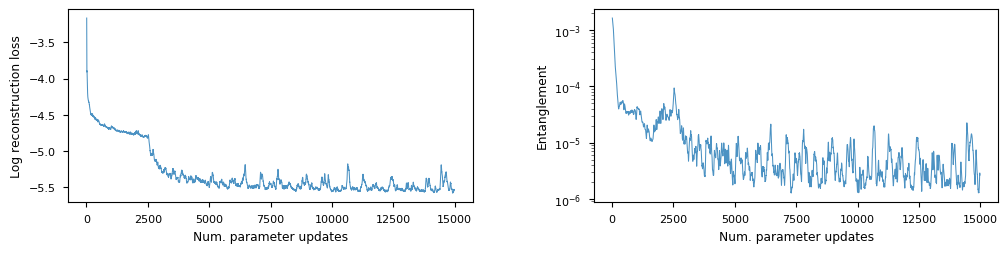

In [20]:
with plt.style.context('seaborn-paper', after_reset=True):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2.5), gridspec_kw={"wspace":0.3})

    window = 25
    avg_mask = np.ones(window) / window

    ax1.plot(np.convolve(range(len(losses)), avg_mask, 'valid'),
             np.convolve(np.log(losses), avg_mask, 'valid'),
             linewidth=0.75,
             alpha=0.8)
#     ax1.set_yscale("log")

    ax1.set_xlabel("Num. parameter updates")
    ax1.set_ylabel("Log reconstruction loss")
    
    ax2.plot(np.convolve(range(len(entanglement)), avg_mask, 'valid'),
             np.convolve(entanglement, avg_mask, 'valid'),
             linewidth=0.75,
             alpha=0.8)
    ax2.set_yscale("log")

    ax2.set_xlabel("Num. parameter updates")
    ax2.set_ylabel("Entanglement")
    
    fig_fname = os.path.join(train_folder, "training_curves")
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

In [21]:
torch.save(decoder.state_dict(), os.path.join(save_folder,"decoder.pth"))
rep_thetas = [rep.thetas for rep in lat_env.action_reps]
torch.save(rep_thetas, os.path.join(save_folder,"representations.pth"))
torch.save(optimizer_dec.state_dict(), os.path.join(train_folder,"optimizer_dec.pth"))
torch.save(optimizer_rep.state_dict(), os.path.join(train_folder,"optimizer_rep.pth"))

### Testing

**1) Show action representations**

[array([ 1.2687328e+00,  5.3777779e-04, -7.5127389e-03,  1.8355068e-02,
       -4.4266582e-03,  1.1433070e-02,  2.0529620e-02, -8.6613800e-03,
       -1.2191871e-02, -2.0282485e-03], dtype=float32), array([-1.2394382 ,  0.0054478 ,  0.0221457 ,  0.01807708,  0.01254465,
        0.03325973,  0.03186062, -0.01183999,  0.00941108,  0.00814397],
      dtype=float32), array([-1.20347105e-02, -1.27251577e+00, -4.72501339e-03,  5.86833153e-03,
       -9.00871772e-03, -4.06470522e-02,  7.86380842e-03,  9.04065091e-04,
       -6.37711585e-03, -1.61028598e-02], dtype=float32), array([ 1.0097982e-02,  1.2616019e+00,  5.7949470e-03, -6.7733941e-03,
        5.3366506e-03, -1.9290835e-02,  1.2613399e-02, -1.4125468e-02,
       -8.7056179e-03,  5.0204340e-04], dtype=float32), array([ 0.00857119, -0.00747742, -0.00785438,  0.01127131, -1.2669499 ,
        0.00886729,  0.02433363, -0.03474601,  0.02565205, -0.00947861],
      dtype=float32), array([ 0.00673865, -0.00695913,  0.01834548, -0.00427401,  1

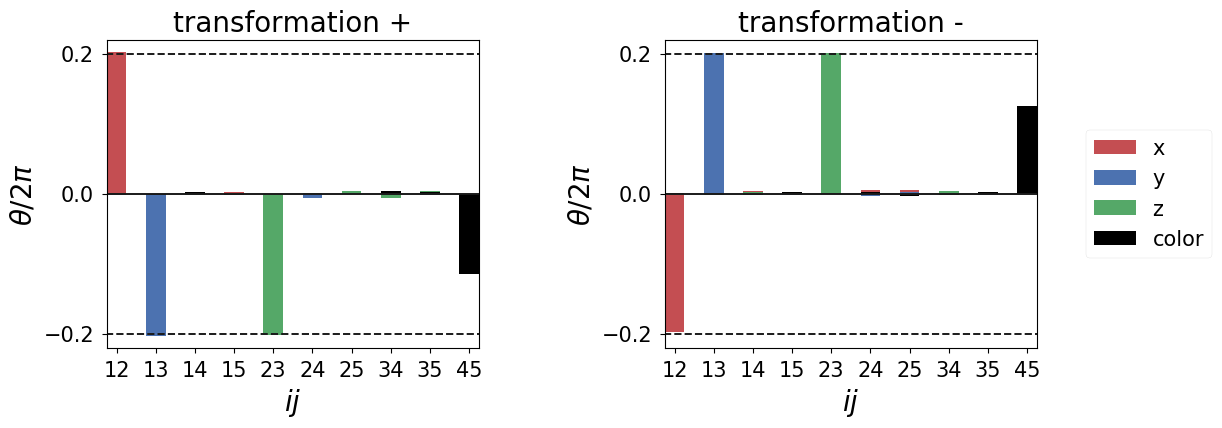

In [22]:
width=0.5

rep_thetas = [rep.thetas.detach().numpy() for rep in lat_env.action_reps]
print(rep_thetas)
plt_lim = max( 0.22, max([max(t) for t in rep_thetas])/(2*np.pi) )
titles = ["transformation +", "transformation -"]
cols=["r","b","g","black"]
labels=["x","y","z","color"]

with plt.style.context('seaborn-paper', after_reset=True):

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace":0.5, "hspace":0.5})
    
    for i, thetas in enumerate(rep_thetas):
        x = np.arange(len(thetas))
        axs[i%2].bar(x - width/2, thetas/(2*np.pi), width, label=labels[i//2], color=cols[i//2])
    for i in range(2):
        axs[i].hlines([0.2,-0.2], xmin=-10, xmax=10, linestyles="dashed")
        axs[i].hlines(0., xmin=-10, xmax=10)
        axs[i].set_yticks([-0.2, 0., 0.2])
        axs[i].set_xticks(x-0.25)
        axs[i].set_xticklabels(["12","13","14","15","23","24","25","34","35","45"], fontsize=10)
        axs[i].set_xlabel("$ij$", fontsize=20)
        
        axs[i].set_ylim(-plt_lim,plt_lim)
        axs[i].set_xlim(-0.5,9)
        axs[i].set_title(titles[i], fontsize=20)
        axs[i].tick_params(labelsize=15)
        
        axs[i].set_ylabel(r"$\theta / 2\pi$", fontsize=20)
    
    axs[1].legend(loc="center right", bbox_to_anchor=(1.5,0.5), fontsize=15)

    fig_fname = os.path.join(test_folder, "thetas")

    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

**2) Show latent space**

Note: this isn't particularly informative, but the general spherical shape of the latent space is visible

[]

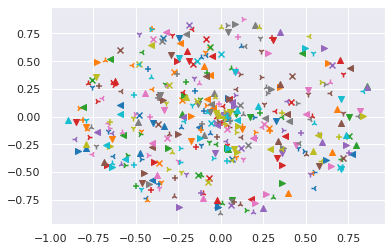

In [23]:
from sklearn.random_projection import GaussianRandomProjection


latent_points = []
radius = 4.

for i in range(20):
    for j in range(20):
        obs = obs_env.reset()
        latent_points.append(encoder(obs).detach().tolist())

latent_map = np.array(latent_points)

pca = GaussianRandomProjection(n_components=2)

latent_2d = pca.fit_transform(latent_map)

#color=["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
marks=["+","1","2","3","4",">","<","^","v","x"]

for i in range (400):
    plt.scatter(latent_map[i][0],
                latent_map[i][1], 
                c=color[i//40], 
                marker=marks[i%10])
plt.plot()





**3) Show predictions**

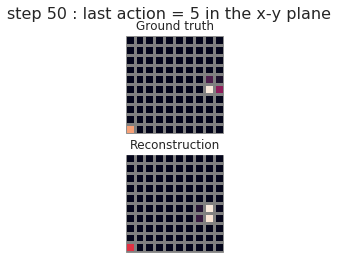

In [24]:
def plot_state(obs, ax):
    ax.pcolormesh(obs.reshape(2*obs_env.size, 2*obs_env.size, 2*obs_env.size).sum(axis=2), edgecolors='gray', linewidth=2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 50

fig, (ax1,ax2) = plt.subplots(2, 1)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = obs_env.reset()
        obs_z = lat_env.reset(encoder(obs_x))
    else:
        action = obs_env.action_space.sample().item()
        obs_x = obs_env.step(action, angle)
        obs_z = lat_env.step(action)
        
    obs_x_recon = decoder(obs_z)
    
    fig.suptitle('step {} : last action = {} in the x-y plane'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2)
    
    fig_fname = os.path.join(test_folder, "step_{}".format(i))

    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.2)
    
display.clear_output(wait=False)